# Analysis of Real Estate Sales in King County, Washington

## Overview

Tasked with creating a predictive model for home prices in King County, Washington, we elected to focus our model on predicting prices with the goal of helping families that earn roughly the median income for a household in Seattle (~$100,000 per year) buy a home that is in their price range and in an area with good schools. 

We used housing sale data from the King County House Sales dataset, student test score data from Washington State's open data portal, and school address information from the Washington School directory to build our model. We tried a variety of approaches in building our model, including log transformations, RFE, and others. Using the strongest of these (r-squared of .71) we created predicted home sale prices for the dataset and compared those predictions to actual sale prices to determine in which zip codes homes are selling for less than we expect, and in which zip codes schools are better than average. 

Based on these factors, we recommend that families look to purchase housing in the 98004 zip code, which is in Bellevue, WA (10 minutes outside of Seattle by car).

## Business Problem

The Agrawal-Gerber Realty Firm assists families moving to King County, Washington in finding a market-rate home in an area with good schools for their kids. To inform our recommendations, we have created a model to predict the price of homes in King County (which comprises Seattle, Bellevue, Kent, and several other small- to mid-sized cities and towns). 

Housing in King County is very expensive (the median home in the dataset of sales county sold for $860,000), so families need to know that their investment represents a good value before they commit to buying a home.

By measuring our predictions against records of actual home sales from 2021 to 2022, we can recommend areas where we believe homes are selling for less than their true value - thus providing families with the ability to buy a home at a good price before the housing market catches up.

## Data Understanding

We used information from three datasets to build our model, all of which are saved in the data folder of our repository:
- Housing sale data from the King County House Sales dataset, which includes the target variable for our models (price) and a wide range of continuous, discrete, and categorical predictor variables, such as zip code, square feet of living space, number of bedrooms, and more.
- Student test score data from Washington State's open data portal, which we used to build a composite measure of average school quality by zip code to use as a predictor for our model.
- School address information from the Washington School directory to build our model, which we used to match schools to zip codes in the King County House Sales dataset.

To begin, we have to import the necessary libraries for our analysis and the King County House Sales dataset.

In [1]:
# Standard Packages
import pandas as pd
import numpy as np
import markdown

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats 

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# SKLearn Modules
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable
pd.options.display.max_columns = None
pd.options.display.width = None

In [2]:
hd = pd.read_csv("data/kc_house_data.csv")
f = open('data/column_names.md', 'r')
desc=markdown.markdown( f.read() )
hd.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591


Let's examine some of the basic properties of our dataset.

In [3]:
# check column names
hd.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [4]:
# check data types
hd.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
greenbelt         object
nuisance          object
view              object
condition         object
grade             object
heat_source       object
sewer_system      object
sqft_above         int64
sqft_basement      int64
sqft_garage        int64
sqft_patio         int64
yr_built           int64
yr_renovated       int64
address           object
lat              float64
long             float64
dtype: object

Some of these columns, such as view, condition, and grade, seem to be ordinal numerical columns. They are not currently stored as the type of variable we will ultimately want them to be to include them in our analysis. Others, such as waterfront, greenbelt, and nuisance, may be good candidates for one-hot encoding. We can dig into these further when we begin processing our data.

In [5]:
# describe the characteristics of the continuous variables in the dataset
hd.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


From this initial examination it seems like there may be at least a few data imputation errors - it's unlikely that there is a home with only 3 square feet of living space, for example. We'll need to make sure to deal with those issues before beginning to build our model. We should also check for null values.

In [6]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

Fortunately, there are very few null values in our dataset - only 32 in heat_source, and 14 in sewer_system. We can wait until we begin to process our data to deal with those.

## Data Preparation

Let's start by dealing with the row for the home that is only 3 square feet.

In [7]:
hd[hd['sqft_living'] <= 100]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
14977,1549500215,12/17/2021,1803000.0,4,4.0,3,326701,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PRIVATE,2,1,1,0,2021,0,"31072 Northeast 165th Street, Duvall, Washingt...",47.745290,-121.92362
28816,2923099027,12/13/2021,205000.0,1,0.0,100,25400,1.0,YES,NO,YES,AVERAGE,Fair,1 Cabin,NaN,NaN,100,0,0,140,1963,0,"49622 172nd Street Southeast, North Bend, Wash...",47.444745,-121.67879


There are two listings for homes in the dataset that are 100 square feet or smaller. The second of these is an oddity but there aren't enough issues to suggest it is included incorrectly in the dataset, whereas the first one is almost certainly an incorrect listing. Let's remove it.

In [8]:
hd.drop(index = 14977, axis = 0, inplace = True)

In building our model, we'll also want to exclude sale listings for homes with no bedrooms or no bathrooms. Our stakeholder (families moving to the area) are not interested in building a home on an empty lot, or making major renovations to prepare it for them to live in – they need a house that's ready for them (even if it's in need of some other work).

In [9]:
# find and drop sales records with no bedrooms or no bathrooms
nobed_nobath = hd.loc[(hd['bedrooms'] == 0) | (hd['bathrooms'] == 0)]
hd.drop(index = nobed_nobath.index, inplace = True, axis = 0)

We'll also want to add a few columns with basic information that isn't already included in the dataset, such as zip code and age of the house.

In [10]:
# add zip column for zipcodes
hd["zip"] = hd['address'].str[-20:-15].astype(int)

# add column for years old and sale year
hd["years_old"] = 2023 - hd["yr_built"]
hd["sale_year"] = hd['date'].str[-4:].astype(int)

Now that we have zip codes for each listing, we'll need to confirm that the dataset includes only homes in King County. To do so, we can create a list of zip codes using the [King County GIS Open Data portal](https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?filters=eyJDT1VOVFlfTkFNRSI6WyJLaW5nIENvdW50eSJdfQ%3D%3D&location=47.503077%2C-121.485100%2C8.71&showTable=true) and compare the zip codes for our records to that list to remove any that aren't in the county.

In [11]:
# create a list of King County zip codes
kingcounty_zips=[98001,98002,98003,98004,98005,98006,98007,98008,
                 98010,98011,98014,98019,98021,98022,98023,98024,
                 98027,98028,98029,98030,98031,98032,98033,98034,
                 98038,98039,98040,98042,98045,98047,98050,98051,
                 98052,98053,98055,98056,98057,98058,98059,98065,
                 98068,98070,98072,98074,98075,98077,98092,98101,
                 98102,98103,98104,98105,98106,98107,98108,98109,
                 98112,98115,98116,98117,98118,98119,98121,98122,
                 98125,98126,98133,98134,98136,98144,98146,98148,
                 98154,98155,98158,98164,98166,98168,98177,98178,
                 98188,98195,98198,98199,98224,98354]

# find rows that have zip codes outside of King County
non_kc_zips = hd.loc[~hd["zip"].isin(kingcounty_zips)]
non_kc_zips.shape

(960, 28)

It looks like 959 of our records are from places other than King County. Let's remove them from our dataset.

In [12]:
# drop rows with zips that are not in King County
hd.drop(index = non_kc_zips.index, inplace = True, axis = 0)
hd

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,54,2022
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133,73,2021
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178,67,2021
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118,13,2021
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027,11,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940,98103,102,2021
30151,194000695,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851,98116,12,2021
30152,7960100080,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585,98122,28,2022
30153,2781280080,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,NONE,Average,8 Good,Gas,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908,98055,17,2022


Let's do a quick check for duplicate values in the 'id' column, since that should be a unique identifier for each listing.

In [13]:
# check to see if there's any values greater than 1
hd['id'].value_counts()

1233100736    2
6632900607    1
3814900660    1
7852180850    1
1332050550    1
             ..
2251500240    1
5253300275    1
5149300370    1
1972202200    1
9430110210    1
Name: id, Length: 29143, dtype: int64

Looks like there's one duplicate listing - let's double check, and if it is a duplicate let's remove it.

In [14]:
# check information for rows with duplicate id values
hd[hd['id'] == 1233100736]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year
4845,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PUBLIC,2590,1410,500,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,98033,4,2021
4846,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PUBLIC,2590,1410,500,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,98033,4,2021


Those listings are identical, so this is almost certainly an accidental duplicate. Let's remove it.

In [15]:
# remove the duplicate based on id
hd = hd.drop_duplicates(subset=["id"])

# check that it's gone 
hd[hd['id'] == 1233100736]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year
4845,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,NO,NONE,Average,9 Better,Gas,PUBLIC,2590,1410,500,290,2019,0,"12611 Northeast 87th Place, Kirkland, Washingt...",47.68069,-122.172135,98033,4,2021


Now that we've done some basic cleaning and feature additions, let's take another look at the description for our data.

In [16]:
hd.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zip,years_old,sale_year
count,2.914300e+04,2.914300e+04,29143.000000,29143.000000,29143.000000,2.914300e+04,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000,29143.000000
mean,4.535778e+09,1.112930e+06,3.441032,2.335518,2132.785060,1.711146e+04,1.516093,1827.233435,481.542738,336.982534,216.534845,1973.841746,93.530934,47.542966,-122.214869,98077.301856,49.158254,2021.361322
std,2.882371e+09,8.928485e+05,0.970083,0.892655,975.893596,6.059826e+04,0.547405,880.057504,586.107600,286.116803,246.591335,31.657508,422.116402,0.146095,0.141524,54.445911,31.657508,0.480392
min,1.000055e+06,2.736000e+04,1.000000,0.500000,290.000000,4.020000e+02,1.000000,290.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.159700,-122.526650,98001.000000,1.000000,2021.000000
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.429703,-122.328268,98032.000000,22.000000,2021.000000
50%,3.869900e+09,8.688000e+05,3.000000,2.500000,1950.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,142.000000,1976.000000,0.000000,47.557440,-122.234275,98059.000000,47.000000,2021.000000
75%,7.286500e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.077300e+04,2.000000,2290.000000,960.000000,520.000000,310.000000,2001.000000,0.000000,47.671700,-122.128011,98117.000000,71.000000,2022.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.789830,-121.417590,98354.000000,123.000000,2022.000000


There are still a wide range of housing types in our dataset, from homes with one bedroom that are only a few hundred feet, to mega-mansions with 13 bedrooms and over 15,000 square feet of space. While we will want to eventually hone in on the target market for our clients, it will be useful to build our model on the largest dataset we can to ensure our price predictions are as accurate as possible. With this initial step done, we can build a baseline model using simple linear regression and iterate from there.

## Baseline Model Construction

To build our baseline model, we'll want to build a simple linear regression model that uses the most strongly-correlated variable with price to make a prediction. Let's take a look at those correlations.

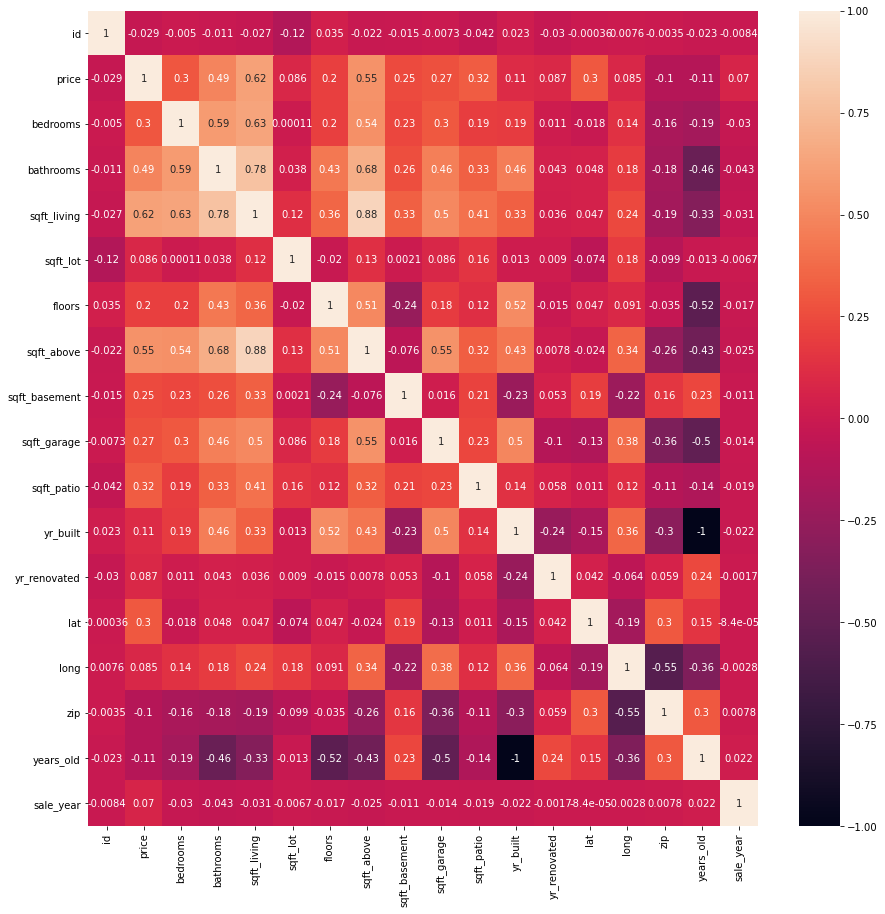

In [17]:
# plot the heatmap to determine correlations
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(hd.corr(), annot=True);

In [18]:
# list correlations in descending order
hd.corr()['price'].map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.620030
sqft_above       0.548955
bathrooms        0.491240
sqft_patio       0.319162
lat              0.299730
bedrooms         0.295056
sqft_garage      0.268707
sqft_basement    0.247081
floors           0.201792
years_old        0.106807
yr_built         0.106807
zip              0.104907
yr_renovated     0.086672
sqft_lot         0.085557
long             0.085403
sale_year        0.070219
id               0.029412
Name: price, dtype: float64

It looks like 'sqft_living,' or square footage of living space in the home, is the most strongly correlated predictor for price. What does that relationship look like?

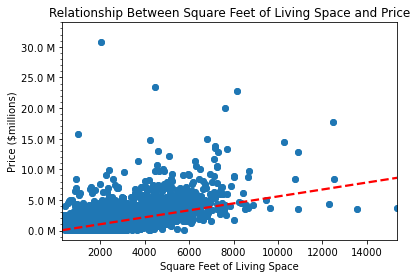

In [19]:
# create plot of square feet of living space vs price
fig, ax = plt.subplots()

plt.scatter(x=hd["sqft_living"], y=hd["price"])
sns.regplot(data = hd, x = 'sqft_living', y = 'price', line_kws={'ls':'--', 'color': 'r'}, ci = None)
ax.set_xlabel('Square Feet of Living Space')
ax.set_ylabel('Price ($millions)')
ax.set_title('Relationship Between Square Feet of Living Space and Price')

# format y axis to show values in millions
def million_formatter(x, pos):
    return "%.1f M" % (x/1E6)

ax.set_yticks(range(-1000000, 35000000, 1000000), minor = True)
ax.yaxis.set_major_formatter(million_formatter);

In general, it looks like there is a positive relationship between living space and price. Let's see how the model performs.

In [20]:
# define variables for simple linear regression
y = hd['price']
X = hd.drop('price', axis = 1)

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .33)

# double check train-test split 
print(f"X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train has {y_train.shape[0]} rows")

X_train has 19525 rows and 27 columns
y_train has 19525 rows


In [21]:
# select our best correlated predictor, as our X Train
baseline_X_train = X_train[['sqft_living']]

# fit our model and show summary
baseline_train_model = sm.OLS(y_train, sm.add_constant(baseline_X_train)).fit()

# find mean absolute error
baseline_mae = baseline_train_model.resid.abs().sum() / len(y)

# print summary of model performance
baseline_train_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.265e+04
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:23:35   Log-Likelihood:            -2.9086e+05
No. Observations:               19525   AIC:                         5.817e+05
Df Residuals:                   19523   BIC:                         5.817e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.239e+05   1.22e+04    -10.147      0.000   -1.48e+05      -1e+05
sqft_living   583.4379      5.187    112.490      0.000     573.272     593.604
==============================================================================
Omnibus:                    28549.652   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         39145872.022
Skew:                           8.342   Prob(JB):                         0.00
Kurtosis:                     221.722   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# print key results for interpretation
print(f"The R-squared value for our baseline model is {baseline_train_model.rsquared:.3f}.")
print(f"The mean absolute error for our baseline model is {baseline_mae:.2f} dollars.")

The R-squared value for our baseline model is 0.393.
The mean absolute error for our baseline model is 271821.93 dollars.


## Baseline Model Evaluation

Unsurprisingly, this initial model does not perform very well. It has an r-squared of only .393, meaning only 39% of the variance in price is explained by square feet of living area. Further, it has a mean absolute error of over $270,000, meaning for any given prediction our model is likely to be off from the true value by that amount. We will need to add more information to our model to improve its accuracy.

## Model 2: Adding More Predictor Variables

For our second model, we want to use more information from the King County House Sales dataset, but we also want to add in information about school quality since that will be a core consideration for our clients in their buying decision. Let's start by importing that data and putting it in a usable format for our dataset.

### Importing and cleaning school quality data

In [23]:
# Import school data
rc = pd.read_csv("data/Report_Card_Assessment_Data_2021-22_School_Year.csv")
addresses=pd.read_csv("data/Washington_School_Directory_20230214.csv")

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Let's take a look at this data.

In [24]:
# look at report card data
rc.head(2)

,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationId,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,SchoolOrganizationId,CurrentSchoolType,StudentGroupType,StudentGroup,GradeLevel,TestAdministration,TestSubject,Suppression,Count of Students Expected to Test,Count of students expected to test including previously passed,CountMetStandard,PercentMetStandard,PercentLevel1,PercentLevel2,PercentLevel3,PercentLevel4,PercentMetTestedOnly,PercentNoScore,DataAsOf
0,2021-22,District,Grays Harbor,Capital Region ESD 113,100004.0,14005.0,Aberdeen School District,100010.0,NaN,District Total,NaN,NaN,FRL,Low-Income,04,SBAC,ELA,None,176.0,176.0,54.0,30.7%,0.460227,0.221591,0.198864,0.107955,0.310345,0.011364,9/7/2022
1,2021-22,District,Grays Harbor,Capital Region ESD 113,100004.0,14005.0,Aberdeen School District,100010.0,NaN,District Total,NaN,NaN,Gender,Female,04,SBAC,ELA,None,107.0,107.0,35.0,32.7%,0.420561,0.224299,0.196262,0.130841,0.336538,0.028037,9/7/2022


Immediately we see some unnecessary columns like SchoolYear, District Code, etc. Let's see what else we want to remove and remove them.

In [25]:
rc.columns

Index(['SchoolYear', 'OrganizationLevel', 'County', 'ESDName',
       'ESDOrganizationId', 'DistrictCode', 'DistrictName',
       'DistrictOrganizationId', 'SchoolCode', 'SchoolName',
       'SchoolOrganizationId', 'CurrentSchoolType', 'StudentGroupType',
       'StudentGroup', 'GradeLevel', 'TestAdministration', 'TestSubject',
       'Suppression', 'Count of Students Expected to Test',
       'Count of students expected to test including previously passed',
       'CountMetStandard', 'PercentMetStandard', 'PercentLevel1',
       'PercentLevel2', 'PercentLevel3', 'PercentLevel4',
       'PercentMetTestedOnly', 'PercentNoScore', 'DataAsOf'],
      dtype='object')

We imported school address information in order to match up average school quality to zip and compare with average sale prices.

In [26]:
# look at school addresses
addresses.head(2)

,ESDCode,ESDName,LEACode,LEAName,SchoolCode,SchoolName,LowestGrade,HighestGrade,AddressLine1,AddressLine2,City,State,ZipCode,PrincipalName,Email,Phone,OrgCategoryList,AYPCode,GradeCategory
0,32801,Educational Service District 101,1109,Washtucna School District,3075,Washtucna Elementary/High School,PK,12,730 East Booth Avenue,NaN,Washtucna,Washington,99371-0688,Vance Wing,vwing@tucna.wednet.edu,509.646.3211,"Public School, Regular School",P,PK-12
1,32801,Educational Service District 101,1122,Benge School District,3142,Benge Elementary,K,6,2978 E. Benge-Winona Rd.,NaN,Benge,Washington,99105-0697,,NaN,NaN,"Public School, Regular School",P,Elementary School


In [27]:
addresses.columns

Index(['ESDCode', 'ESDName', 'LEACode', 'LEAName', 'SchoolCode', 'SchoolName',
       'LowestGrade', 'HighestGrade', 'AddressLine1', 'AddressLine2', 'City',
       'State', 'ZipCode', 'PrincipalName', 'Email', 'Phone',
       'OrgCategoryList', 'AYPCode', 'GradeCategory'],
      dtype='object')

Both of these data sets include school names, which will allow us to join the information we need from each into a new dataset that includes school performance information from 'rc' and school location information from 'addresses.' Our approach will be to first narrow this both data sets to only schools in King County, and then create a composite performance metric based on the "PercentMetStandard" column from the 'rc' DataFrame.

In [28]:
# clean up Addresses dataframe
# extract zip codes
addresses["ZipCode"] = addresses["ZipCode"].apply(lambda x: x[:5])
addresses["ZipCode"] = addresses["ZipCode"].astype(int)

# remove non-King County schools
non_kc_addresses = addresses.loc[~addresses['ZipCode'].isin(kingcounty_zips)]
non_kc_zips = hd.loc[~hd["zip"].isin(kingcounty_zips)]
addresses.drop(index = non_kc_addresses.index, inplace = True, axis = 0)

# keep only necessary information
addresses=addresses[["SchoolName", "ZipCode"]]
addresses.head(2)

,SchoolName,ZipCode
803,Middle College High School,98125
804,Tops K-8 School,98102


We only want schools in King County, schools and not districts, and we want to look at the "all grades" averages as opposed to individual grades, just to ensure we have the same numbers from all the schools.

In [29]:
# clean up Report Card dataframe
# keep only necessary columns
rc = rc[["OrganizationLevel", "County", "SchoolName", "GradeLevel", "TestSubject", "PercentMetStandard"]]

# drop extraneous rows
rc = rc[rc["County"] == "King"].drop(columns=["County"])
rc = rc[rc["OrganizationLevel"] == "School"].drop(columns=["OrganizationLevel"])
rc = rc[rc["GradeLevel"] == "All Grades"].drop(columns=["GradeLevel"])
rc.head(2)

,SchoolName,TestSubject,PercentMetStandard
14611,Interagency Programs,Science,13.6%
14612,Interagency Programs,Science,7.1%


In [30]:
# check dtypes for record card dataframe
rc.dtypes

SchoolName            object
TestSubject           object
PercentMetStandard    object
dtype: object

We have a lot of strings in our "PercentMetStandard" column where we want numbers. Let's swap them out.

In [31]:
# clean and data under percent met standard column to cast as float
rc["PercentMetStandard"]=rc["PercentMetStandard"].replace("Suppressed: N<10", "0.0%")
rc["PercentMetStandard"]=rc["PercentMetStandard"].replace("No Students", "0.0%")
rc["PercentMetStandard"]=rc["PercentMetStandard"].apply(lambda x: x.strip("%"))
rc["PercentMetStandard"]=rc["PercentMetStandard"].apply(lambda x: x.strip(">"))
rc["PercentMetStandard"]=rc["PercentMetStandard"].apply(lambda x: x.strip("<"))
rc["PercentMetStandard"]=rc["PercentMetStandard"].astype(float)

# average test scores by school and create a ratings column
rc = rc.groupby(["SchoolName"]).aggregate({"PercentMetStandard":"mean"}).sort_values(by=["SchoolName"]).reset_index()
rc["rating"] = rc["PercentMetStandard"]/10

Now we have a school rating metric that is based on state test performance. What does the distribution of this metric look like?

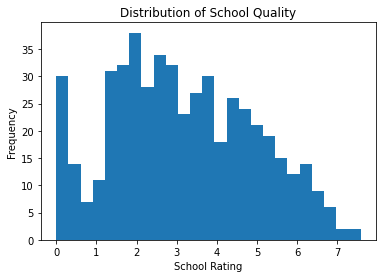

In [32]:
# create a histogram 
fig, ax = plt.subplots()
rc['rating'].plot.hist(bins = 25)
ax.set_xlabel('School Rating')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of School Quality');

Looks like the data is somewhat right-skewed, but also has a peak near 0. Down the line, we'll probably need to figure out a way to normalize this distribution to maximize its utility in our analysis. How does it relate to home prices?

In [33]:
# join dataframes and remove excess columns
schools = rc.merge(addresses, left_on="SchoolName", right_on="SchoolName")
schools = schools[["SchoolName", "rating", "ZipCode"]]
schools["ZipCode"] = schools["ZipCode"].astype(int)

# create dictionary with zip codes and average school rating for that zip
schools_dict = dict(zip(schools.ZipCode, round(schools.rating, 1)))

# add ratings to the X_train dataframe using zips
X_train['avg_school_quality'] = X_train['zip'].map(schools_dict)

In [34]:
X_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year,avg_school_quality
25057,8566100220,5/31/2022,6,4.5,4550,13366,2.0,NO,NO,NO,NONE,Good,9 Better,Gas,PUBLIC,3650,900,420,250,1967,0,"7405 92nd Place Southeast, Mercer Island, Wash...",47.536455,-122.21720,98040,56,2022,6.2
2550,3629860030,9/10/2021,5,3.5,3910,4295,2.0,NO,YES,NO,NONE,Average,9 Better,Gas,PUBLIC,3170,740,560,80,2004,0,"1977 16th Court Northeast, Issaquah, Washingto...",47.548840,-122.00823,98029,19,2021,5.1


Excellent – now we've assigned each sale listing an average school quality based on its zip code. Does it look like there's a relationship between these two variables?

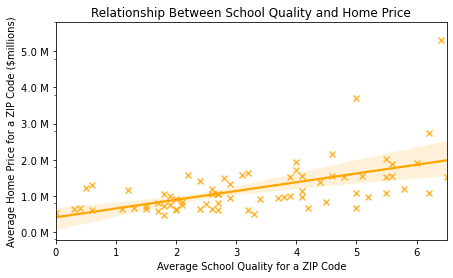

In [35]:
# create dataframe with average sale price, average school rating, and zip
prices = hd[["zip", "price"]].groupby(by=["zip"]).mean().reset_index()
schools = X_train[["avg_school_quality", "zip"]].groupby(by=["zip"]).mean().reset_index()
schools_prices = prices.merge(schools, left_on="zip", right_on="zip")

# visualize relationship between average sale price and average school rating
fig, ax = plt.subplots(figsize = (7, 4))
ax = sns.regplot(x=schools_prices["avg_school_quality"], 
                   y=schools_prices["price"], 
                   color = "orange", 
                   marker = "x")
ax.set_xlabel('Average School Quality for a ZIP Code')
ax.set_ylabel('Average Home Price for a ZIP Code ($millions)')
ax.set_title('Relationship Between School Quality and Home Price')
ax.set_yticks(range(-200000, 6000000, 1000000), minor = True)
ax.yaxis.set_major_formatter(million_formatter);

### Processing Categorical Variables

Now that we have assigned each listing an average school quality rating based on its zip code, let's handle the rest of our categorical variables. Some are ordinal and will require ordinal encoding; others are boolean and will require one-hot encoding. We'll start with the ordinal variables.

In [36]:
# create dictionaries for assigning ordinal values to appropriate columns
scale_mapper1 = {"NONE":0, "FAIR": 1, "AVERAGE":2, "GOOD":3, "EXCELLENT":4}
X_train["view"] = X_train["view"].replace(scale_mapper1)

scale_mapper2 = {"Poor":0, "Fair": 1, "Average":2, "Good":3, "Very Good":4}
X_train["condition"] = X_train["condition"].replace(scale_mapper2)

scale_mapper3 = {"1 Cabin":1, "2 Substandard": 2, "3 Poor":3, "4 Low":4, "5 Fair":5, 
               "6 Low Average":6, "7 Average": 7, "8 Good":8, "9 Better":9, "10 Very Good":10,
               "11 Excellent": 11, "12 Luxury":12, "13 Mansion":13 }
X_train["grade"] = X_train["grade"].replace(scale_mapper3)

In [37]:
# sanity check 
X_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year,avg_school_quality
25057,8566100220,5/31/2022,6,4.5,4550,13366,2.0,NO,NO,NO,0,3,9,Gas,PUBLIC,3650,900,420,250,1967,0,"7405 92nd Place Southeast, Mercer Island, Wash...",47.536455,-122.21720,98040,56,2022,6.2
2550,3629860030,9/10/2021,5,3.5,3910,4295,2.0,NO,YES,NO,0,2,9,Gas,PUBLIC,3170,740,560,80,2004,0,"1977 16th Court Northeast, Issaquah, Washingto...",47.548840,-122.00823,98029,19,2021,5.1


Looks like that worked for the View, Condition, and Grade columns. Next, we'll process the "yr_renovated" column. From our data exploration at the beginning we can see that at least 75% of the listings in this dataset have a "0" in that column, implying they've never been renovated. It will probably be more useful to our analysis to alter the information we use from that column so that it is a boolean - 0 for "has never been renovated," 1 for "has been renovated."

In [38]:
X_train['yr_renovated'].value_counts()

0       18599
2021       48
2018       34
2005       32
2006       31
        ...  
1930        1
1972        1
1928        1
1958        1
1946        1
Name: yr_renovated, Length: 79, dtype: int64

In [39]:
# create a new column with a boolean value
X_train['renovated'] = np.where(X_train['yr_renovated'] > 0, 1, 0)

# drop the old column
X_train.drop('yr_renovated', axis = 1, inplace = True)
X_train['renovated'].value_counts()

0    18599
1      926
Name: renovated, dtype: int64

The number of zeroes for each column lines up, so it looks like it worked properly. Now, let's one-hot encode each of the columns that has a boolean value - waterfront, greenbelt, nuisance, and renovated.

In [40]:
# one hot encoding categorical variables and dropping first column to avoid dummy variable trap
X_train = pd.get_dummies(X_train, columns = ['waterfront', 'greenbelt', 'nuisance', 'renovated'], drop_first = True)
X_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,address,lat,long,zip,years_old,sale_year,avg_school_quality,waterfront_YES,greenbelt_YES,nuisance_YES,renovated_1
25057,8566100220,5/31/2022,6,4.5,4550,13366,2.0,0,3,9,Gas,PUBLIC,3650,900,420,250,1967,"7405 92nd Place Southeast, Mercer Island, Wash...",47.536455,-122.21720,98040,56,2022,6.2,0,0,0,0
2550,3629860030,9/10/2021,5,3.5,3910,4295,2.0,0,2,9,Gas,PUBLIC,3170,740,560,80,2004,"1977 16th Court Northeast, Issaquah, Washingto...",47.548840,-122.00823,98029,19,2021,5.1,0,1,0,0


Finally, let's drop some of the values that we won't be using in our analysis - id, date, heat source, sewer system, address, lat, long, and sale year (since our exploration also revealed that all sales occurred in either 2021 or 2022).

In [41]:
X_train.drop(columns=["id", "date", "heat_source", "sewer_system", "address", "lat", "long", "sale_year"], inplace = True)

Let's examine our new training dataset to make sure there are no missing values before we proceed.

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19525 entries, 25057 to 24488
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            19525 non-null  int64  
 1   bathrooms           19525 non-null  float64
 2   sqft_living         19525 non-null  int64  
 3   sqft_lot            19525 non-null  int64  
 4   floors              19525 non-null  float64
 5   view                19525 non-null  int64  
 6   condition           19525 non-null  int64  
 7   grade               19525 non-null  int64  
 8   sqft_above          19525 non-null  int64  
 9   sqft_basement       19525 non-null  int64  
 10  sqft_garage         19525 non-null  int64  
 11  sqft_patio          19525 non-null  int64  
 12  yr_built            19525 non-null  int64  
 13  zip                 19525 non-null  int64  
 14  years_old           19525 non-null  int64  
 15  avg_school_quality  19506 non-null  float64
 16  

There are a small number of missing values in our average school quality column. We will impute the mean school quality for those missing values, since it represents a very small portion of our dataset and therefore will not have too significant of an impact on the variance of the data.

In [43]:
# impute mean average school quality for missing values
X_train.loc[X_train['avg_school_quality'].isna()] = X_train['avg_school_quality'].mean()

# check that it worked
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19525 entries, 25057 to 24488
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            19525 non-null  float64
 1   bathrooms           19525 non-null  float64
 2   sqft_living         19525 non-null  float64
 3   sqft_lot            19525 non-null  float64
 4   floors              19525 non-null  float64
 5   view                19525 non-null  float64
 6   condition           19525 non-null  float64
 7   grade               19525 non-null  float64
 8   sqft_above          19525 non-null  float64
 9   sqft_basement       19525 non-null  float64
 10  sqft_garage         19525 non-null  float64
 11  sqft_patio          19525 non-null  float64
 12  yr_built            19525 non-null  float64
 13  zip                 19525 non-null  float64
 14  years_old           19525 non-null  float64
 15  avg_school_quality  19525 non-null  float64
 16  

### Running the all variable model

Now that we have a complete, clean dataset, let's run a multiple variable model and see how it performs in comparison to the baseline model.

In [44]:
# create a copy of our X_train for running the all variable model
all_variable_X = X_train.copy()

# instantiate and fit the all variable model
all_variable_model = sm.OLS(y_train, sm.add_constant(all_variable_X)).fit()

# find mean absolute error
all_variable_mae = all_variable_model.resid.abs().sum() / len(y)

all_variable_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     1136.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:23:38   Log-Likelihood:            -2.8820e+05
No. Observations:               19525   AIC:                         5.764e+05
Df Residuals:                   19504   BIC:                         5.766e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.735e+06   2.29e+05    -16.322      0.000   -4.18e+06   -3.29e+06
bedrooms           -1.116e+05   6379.509    -17.486      0.000   -1.24e+05    -9.9e+04
bathrooms           1.053e+05   9234.020     11.404      0.000    8.72e+04    1.23e+05
sqft_living          142.9652     20.788      6.877      0.000     102.219     183.712
sqft_lot              -0.2178      0.074     -2.931      0.003      -0.364      -0.072
floors             -1.174e+05   1.17e+04    -10.039      0.000    -1.4e+05   -9.45e+04
view                7.914e+04   6138.093     12.893      0.000    6.71e+04    9.12e+04
condition            2.92e+04   7062.142      4.135      0.000    1.54e+04     4.3e+04
grade                2.21e+05   6731.553     32.832      0.000    2.08e+05    2.34e+05
sqft_above           300.0324     20.979     14.302      0.000     258.912     341.152
sqft_basement        128.4730     15.551      8.262      0.000      97.992     158.954
sqft_garage         -202.1504     22.343     -9.047      0.000    -245.945    -158.356
sqft_patio            92.7986     20.545      4.517      0.000      52.528     133.069
yr_built            8431.3201   4658.798      1.810      0.070    -700.323    1.76e+04
zip                 -153.3498     95.894     -1.599      0.110    -341.311      34.611
years_old           1.202e+04   4708.859      2.552      0.011    2787.421    2.12e+04
avg_school_quality  9.377e+04   2817.473     33.281      0.000    8.82e+04    9.93e+04
waterfront_YES      9.233e+05   3.72e+04     24.846      0.000     8.5e+05    9.96e+05
greenbelt_YES       1.653e+04   2.88e+04      0.574      0.566   -3.99e+04    7.29e+04
nuisance_YES        4.274e+04   1.22e+04      3.509      0.000    1.89e+04    6.66e+04
renovated_1         4.149e+04   2.26e+04      1.834      0.067   -2845.538    8.58e+04
==============================================================================
Omnibus:                    29693.311   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         58025072.753
Skew:                           8.927   Prob(JB):                         0.00
Kurtosis:                     269.468   Cond. No.                     5.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# print key results for interpretation
print(f"The R-squared value for our all variable model is {all_variable_model.rsquared:.3f}.")
print(f"The mean absolute error for our all variable model is {all_variable_mae:.2f} dollars.")
print('\n')
print(f"The R-squared value for our baseline model is {baseline_train_model.rsquared:.3f}.")
print(f"The mean absolute error for our baseline model is {baseline_mae:.2f} dollars.")

The R-squared value for our all variable model is 0.538.
The mean absolute error for our all variable model is 231711.69 dollars.


The R-squared value for our baseline model is 0.393.
The mean absolute error for our baseline model is 271821.93 dollars.


### All Variable Model Evaluation

This model performed substantially better than the single variable model. Our r-squared increase from 39% to 53.8%, which indicates that the model explains the variance in price about 15 percentage points better than the simple model did. Further, our mean absolute error went down by roughly $40,000, which indicates that our model's predictions are off from reality by that much less on average. 

However, there is still substantial room for improvement. The model suffers from significant multicollinearity as indicated by its high condition number, and includes some non-significant coefficients (p > .05). We can improve our model further by transforming some of our variables to make their distributions more normal, removing variables that may be causing multicollinearity, and reassessing to see if there are still any insignificant predictors after those changes.

## Transforming Variables

Let's look at the distribution of our variables to see if there are any that may violate the assumptions of linear regression.

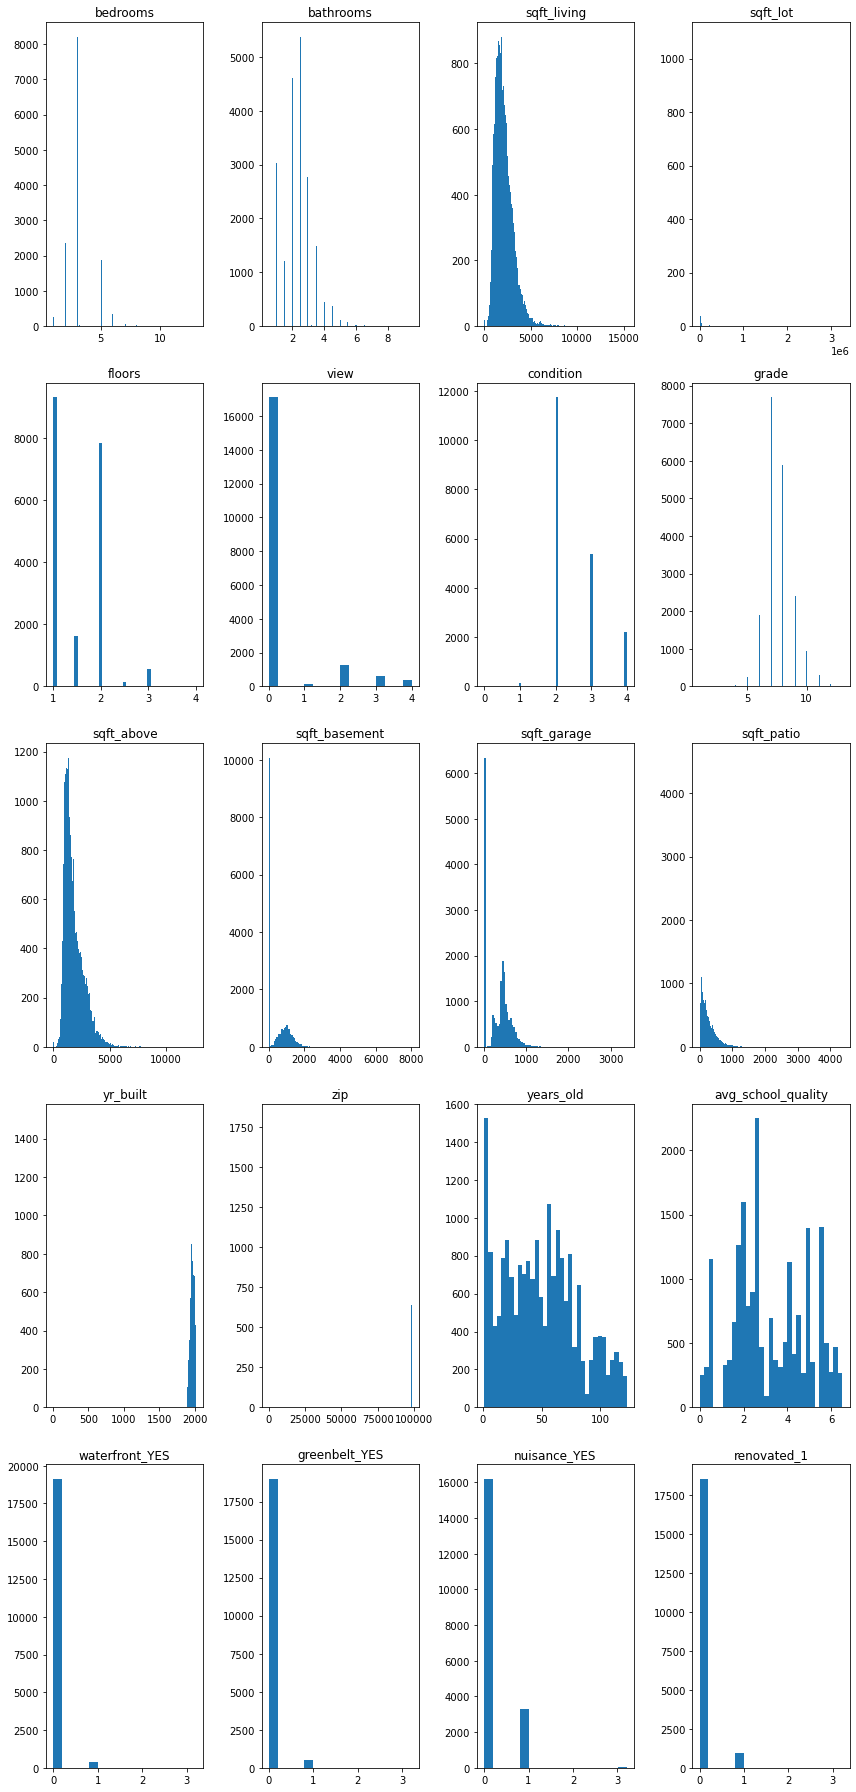

In [46]:
# set up figure for predictor variables in all_variable_X
fig, axes = plt.subplots(nrows=(all_variable_X.shape[1] // 4), ncols=4, figsize=(12,25))

# plot distribution for each col in all_variable_X
for col, ax in zip(all_variable_X, axes.flatten()):
    ax.hist(all_variable_X[col], bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

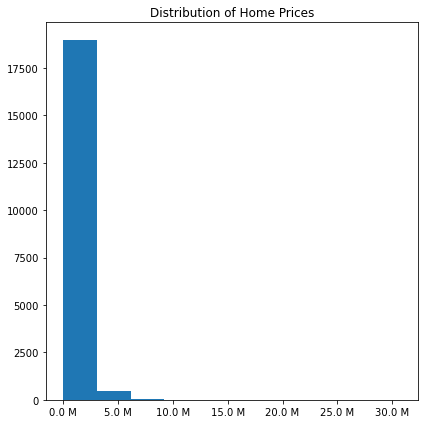

In [47]:
# set up figure for price
fig, ax = plt.subplots(figsize=(6,6))

# plot distribution for price
ax.hist(y_train)
ax.set_title('Distribution of Home Prices')
ax.xaxis.set_major_formatter(million_formatter)
    
fig.tight_layout();

Some of these predictor variables are heavily skewed to the right, as is our outcome. We can fix this by using a log transformation - let's do that now.

In [48]:
# selecting variables for log transformation
log_variables = ['sqft_living','sqft_above', 'years_old']

# assign to X_logs
X_logs = all_variable_X[log_variables]
X_logs.head(2)

,sqft_living,sqft_above,years_old
25057,4550.0,3650.0,56.0
2550,3910.0,3170.0,19.0


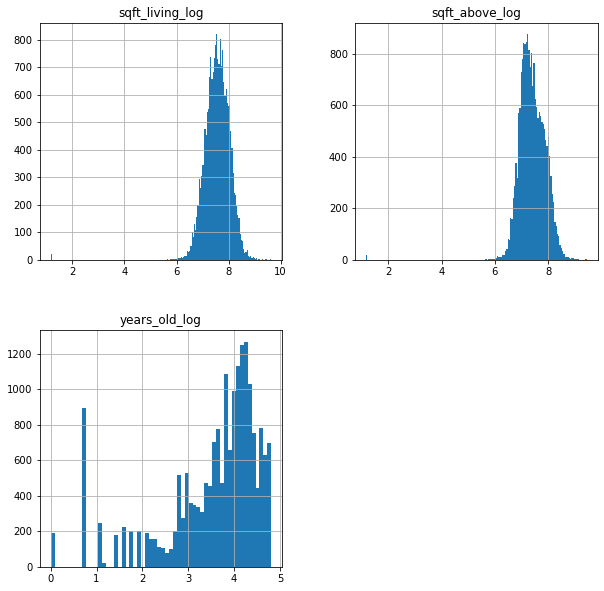

In [49]:
# perform log transformation and plot new distributions
log_columns = [f'{column}_log' for column in X_logs.columns]
cont_log = np.log(X_logs)
cont_log.columns = log_columns
cont_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

That looks better. Let's add those back to our dataset, and drop the original columns. We can also simultaneously drop some columns that may be causing multicollinearity. For example, since we are including square feet of living space (as a log-transformed value), we can drop most of the other measures of square footage.

In [50]:
log_transformed = cont_log.join(all_variable_X)
log_transformed.drop(columns = ["sqft_living", "sqft_above", "sqft_lot", 'years_old',
                                 "yr_built", "sqft_basement", "sqft_garage", "sqft_patio",],
                     inplace = True)
log_transformed

,sqft_living_log,sqft_above_log,years_old_log,bedrooms,bathrooms,floors,view,condition,grade,zip,avg_school_quality,waterfront_YES,greenbelt_YES,nuisance_YES,renovated_1
25057,8.422883,8.202482,4.025352,6.0,4.5,2.0,0.0,3.0,9.0,98040.0,6.2,0.0,0.0,0.0,0.0
2550,8.271293,8.061487,2.944439,5.0,3.5,2.0,0.0,2.0,9.0,98029.0,5.1,0.0,1.0,0.0,0.0
19293,7.501082,7.501082,2.772589,3.0,2.5,2.0,0.0,2.0,8.0,98053.0,4.1,0.0,0.0,0.0,0.0
18968,7.522941,7.522941,4.574711,3.0,1.5,1.5,0.0,1.0,7.0,98070.0,5.2,0.0,0.0,1.0,0.0
20007,7.951559,7.420579,3.871201,4.0,3.0,1.0,0.0,3.0,8.0,98058.0,1.9,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22337,6.709304,6.709304,4.394449,2.0,1.0,1.0,0.0,3.0,7.0,98133.0,2.5,0.0,0.0,0.0,0.0
5559,7.365180,7.192934,4.204693,4.0,2.0,1.0,0.0,3.0,7.0,98106.0,1.3,0.0,0.0,0.0,0.0
883,7.461640,7.461640,3.433987,3.0,2.5,2.0,0.0,3.0,8.0,98029.0,5.1,0.0,0.0,0.0,0.0
16336,8.048788,7.832014,2.890372,5.0,1.5,2.0,0.0,2.0,8.0,98065.0,1.2,0.0,1.0,0.0,0.0


Now that we have transformed our predictor variables, let's do the same to our outcome to reduce its skew as well.

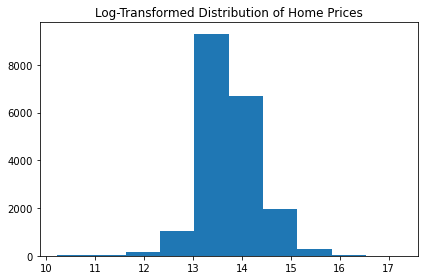

In [51]:
# log transform outcome
log_y = np.log(y_train)

# set up figure for log-transformed price
fig, ax = plt.subplots(figsize=(6,4))

# plot distribution of log-transformed price
ax.hist(log_y)
ax.set_title('Log-Transformed Distribution of Home Prices')
    
fig.tight_layout();

That distribution looks much better. Now that we've normalized the distribution of some of our variables, let's run another model to see if it makes a difference.

## Model 3: Log-Transformed Variables

In [52]:
# instantiate and fit the model
log_model = sm.OLS(log_y, sm.add_constant(log_transformed)).fit()

# show a summary of results
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     1536.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:24:01   Log-Likelihood:                -9718.9
No. Observations:               19525   AIC:                         1.947e+04
Df Residuals:                   19509   BIC:                         1.960e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.8167      0.142     68.912      0.000       9.537      10.096
sqft_living_log        0.2934      0.018     16.307      0.000       0.258       0.329
sqft_above_log         0.0259      0.015      1.731      0.083      -0.003       0.055
years_old_log          0.0559      0.004     14.889      0.000       0.049       0.063
bedrooms              -0.0169      0.004     -3.969      0.000      -0.025      -0.009
bathrooms              0.0672      0.006     11.917      0.000       0.056       0.078
floors                 0.0110      0.007      1.498      0.134      -0.003       0.025
view                   0.0621      0.004     16.192      0.000       0.055       0.070
condition              0.0422      0.004      9.548      0.000       0.034       0.051
grade                  0.1783      0.004     43.758      0.000       0.170       0.186
zip                -6.036e-06   1.68e-06     -3.594      0.000   -9.33e-06   -2.74e-06
avg_school_quality     0.0905      0.002     51.145      0.000       0.087       0.094
waterfront_YES         0.2388      0.024     10.112      0.000       0.193       0.285
greenbelt_YES          0.0848      0.018      4.626      0.000       0.049       0.121
nuisance_YES           0.0271      0.008      3.508      0.000       0.012       0.042
renovated_1            0.0960      0.014      6.834      0.000       0.068       0.124
==============================================================================
Omnibus:                     5841.510   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72145.055
Skew:                          -1.085   Prob(JB):                         0.00
Kurtosis:                      12.163   Cond. No.                     4.93e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
print(f"The R-squared value for our log-transformed model is {log_model.rsquared:.3f}.")
print('\n')
print(f"The R-squared value for our all-variable model is {all_variable_model.rsquared:.3f}.")
print(f"The mean absolute error for our all-variable model is {all_variable_mae:.2f} dollars.")
print('\n')
print(f"The R-squared value for our baseline model is {baseline_train_model.rsquared:.3f}.")
print(f"The mean absolute error for our baseline model is {baseline_mae:.2f} dollars.")

The R-squared value for our log-transformed model is 0.541.


The R-squared value for our all-variable model is 0.538.
The mean absolute error for our all-variable model is 231711.69 dollars.


The R-squared value for our baseline model is 0.393.
The mean absolute error for our baseline model is 271821.93 dollars.


### Log-transformed Model Evaluation

This model performed only somewhat better than the all-variable model. However, there is one more key change we can make to this model to improve its performance.

## 'Final' Model: One-Hot Encoded ZIP Codes

The model is currently treating ZIP codes as a numerical variable, but in reality they are a categorical variable. We'll need to one-hot encode them to include them properly in our model.

In [54]:
# one-hot encode zip column
log_transformed_zips = pd.get_dummies(log_transformed, columns = ['zip'], drop_first = True)
log_transformed_zips.columns

Index(['sqft_living_log', 'sqft_above_log', 'years_old_log', 'bedrooms',
       'bathrooms', 'floors', 'view', 'condition', 'grade',
       'avg_school_quality', 'waterfront_YES', 'greenbelt_YES', 'nuisance_YES',
       'renovated_1', 'zip_98001.0', 'zip_98002.0', 'zip_98003.0',
       'zip_98004.0', 'zip_98005.0', 'zip_98006.0', 'zip_98007.0',
       'zip_98008.0', 'zip_98010.0', 'zip_98011.0', 'zip_98014.0',
       'zip_98019.0', 'zip_98022.0', 'zip_98023.0', 'zip_98024.0',
       'zip_98027.0', 'zip_98028.0', 'zip_98029.0', 'zip_98030.0',
       'zip_98031.0', 'zip_98032.0', 'zip_98033.0', 'zip_98034.0',
       'zip_98038.0', 'zip_98039.0', 'zip_98040.0', 'zip_98042.0',
       'zip_98045.0', 'zip_98047.0', 'zip_98051.0', 'zip_98052.0',
       'zip_98053.0', 'zip_98055.0', 'zip_98056.0', 'zip_98057.0',
       'zip_98058.0', 'zip_98059.0', 'zip_98065.0', 'zip_98070.0',
       'zip_98072.0', 'zip_98074.0', 'zip_98075.0', 'zip_98077.0',
       'zip_98092.0', 'zip_98102.0', 'zip_98103.0'

In [55]:
# run model again with one-hot encoded zips
log_zips_model = sm.OLS(log_y, sm.add_constant(log_transformed_zips)).fit()
log_zips_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     547.8
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:24:02   Log-Likelihood:                -5315.6
No. Observations:               19525   AIC:                         1.081e+04
Df Residuals:                   19438   BIC:                         1.149e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  9.7920      0.114     85.879      0.000       9.569      10.016
sqft_living_log        0.2072      0.015     14.214      0.000       0.179       0.236
sqft_above_log         0.2629      0.013     19.555      0.000       0.237       0.289
years_old_log         -0.0115      0.003     -3.498      0.000      -0.018      -0.005
bedrooms              -0.0052      0.003     -1.515      0.130      -0.012       0.002
bathrooms              0.0411      0.005      9.044      0.000       0.032       0.050
floors                -0.0799      0.007    -12.063      0.000      -0.093      -0.067
view                   0.0681      0.003     21.460      0.000       0.062       0.074
condition              0.0648      0.004     17.983      0.000       0.058       0.072
grade                  0.0921      0.003     26.365      0.000       0.085       0.099
avg_school_quality     0.2537      0.002    128.700      0.000       0.250       0.258
waterfront_YES         0.3201      0.019     16.602      0.000       0.282       0.358
greenbelt_YES          0.0763      0.015      5.051      0.000       0.047       0.106
nuisance_YES          -0.0370      0.006     -5.869      0.000      -0.049      -0.025
renovated_1            0.0693      0.011      6.134      0.000       0.047       0.091
zip_98001.0           -0.9708      0.136     -7.115      0.000      -1.238      -0.703
zip_98002.0           -1.3363      0.136     -9.814      0.000      -1.603      -1.069
zip_98003.0           -1.3335      0.136     -9.800      0.000      -1.600      -1.067
zip_98004.0           -0.8059      0.136     -5.929      0.000      -1.072      -0.539
zip_98005.0           -1.0374      0.138     -7.526      0.000      -1.308      -0.767
zip_98006.0           -1.4824      0.135    -11.018      0.000      -1.746      -1.219
zip_98007.0           -0.6904      0.138     -4.994      0.000      -0.961      -0.419
zip_98008.0           -1.2542      0.135     -9.274      0.000      -1.519      -0.989
zip_98010.0           -1.8440      0.136    -13.538      0.000      -2.111      -1.577
zip_98011.0           -0.8983      0.137     -6.540      0.000      -1.168      -0.629
zip_98014.0           -1.5211      0.139    -10.967      0.000      -1.793      -1.249
zip_98019.0           -1.4000      0.137    -10.185      0.000      -1.669      -1.131
zip_98022.0           -1.2988      0.137     -9.497      0.000      -1.567      -1.031
zip_98023.0           -1.6579      0.135    -12.241      0.000      -1.923      -1.392
zip_98024.0           -1.6525      0.139    -11.905      0.000      -1.925      -1.380
zip_98027.0           -1.3835      0.135    -10.220      0.000      -1.649      -1.118
zip_98028.0           -1.8947      0.136    -13.944      0.000      -2.161      -1.628
zip_98029.0           -1.4177      0.1

In [56]:
print(f"The R-squared value for our one-hot encoded zips model is {log_zips_model.rsquared:.3f}.")
print('\n')
print(f"The R-squared value for our log-transformed model is {log_model.rsquared:.3f}.")
print('\n')
print(f"The R-squared value for our all-variable model is {all_variable_model.rsquared:.3f}.")
print(f"The mean absolute error for our all-variable model is {all_variable_mae:.2f} dollars.")
print('\n')
print(f"The R-squared value for our baseline model is {baseline_train_model.rsquared:.3f}.")
print(f"The mean absolute error for our baseline model is {baseline_mae:.2f} dollars.")

The R-squared value for our one-hot encoded zips model is 0.708.


The R-squared value for our log-transformed model is 0.541.


The R-squared value for our all-variable model is 0.538.
The mean absolute error for our all-variable model is 231711.69 dollars.


The R-squared value for our baseline model is 0.393.
The mean absolute error for our baseline model is 271821.93 dollars.


### One-Hot Encoded Zip Codes Model Evaluation

This model is by far our strongest, which makes sense - similarly-priced homes are likely to be clustered together in the same ZIP code, so using ZIP code as a predictor for home price adds an important geographic predictor to our model that was previously absent after we eliminated latitude and longitude as predictors. This is the model we will use in making our predictions and recommendations.

### Testing the One-Hot Encoded Zip Codes Model Against Our Test Data

Now that we have a model with a sufficiently high r-squared, let's test it against our test data set.

In [57]:
#adding school data
X_test['avg_school_quality'] = X_test['zip'].map(schools_dict)
X_test.loc[X_test['avg_school_quality'].isna()] = X_test['avg_school_quality'].mean()

#convert values for view, condition, and grade
X_test["view"] = X_test["view"].replace(scale_mapper1)
X_test["condition"] = X_test["condition"].replace(scale_mapper2)
X_test["grade"] = X_test["grade"].replace(scale_mapper3)

#convert renovated columns
X_test['renovated'] = np.where(X_test['yr_renovated'] > 0, 1, 0)
X_test.drop('yr_renovated', axis = 1, inplace = True)

#one-hot encode waterfront, greenbelt, nuisance, and renovated
X_test = pd.get_dummies(X_test, columns = ['waterfront', 'greenbelt', 'nuisance', 'renovated'], drop_first = True)
X_test = X_test.drop(columns=['waterfront_NO', 'greenbelt_NO', 'nuisance_NO'])

#drop unnecessary columns
X_test = X_test.drop(columns=["id", "heat_source", "sewer_system", "address", "lat", "long", "date", "sale_year"])

In [58]:
# log transform appropriate X columns
X_test_logs = X_test[log_variables]
log_columns_test = [f'{column}_log' for column in X_test_logs.columns]
cont_log_test = np.log(X_test_logs)
cont_log_test.columns = log_columns_test

log_transformed_test = cont_log_test.join(X_test).drop(columns = ["sqft_living", "sqft_above", "sqft_lot", 
                                                                  'years_old', "yr_built", "sqft_basement", 
                                                                  "sqft_garage", "sqft_patio"])



log_transformed_zips_test = pd.get_dummies(log_transformed_test, columns = ['zip'], drop_first = True)

log_y_test = np.log(y_test)

In [59]:
# run the model with the test data
test_model = sm.OLS(log_y_test, sm.add_constant(log_transformed_zips_test)).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     246.0
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:24:02   Log-Likelihood:                -2774.1
No. Observations:                9618   AIC:                             5722.
Df Residuals:                    9531   BIC:                             6346.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.3730      0.113    101.013      0.000      11.152      11.594
sqft_living_log        0.2382      0.021     11.170      0.000       0.196       0.280
sqft_above_log         0.2636      0.020     13.428      0.000       0.225       0.302
years_old_log         -0.0032      0.005     -0.676      0.499      -0.013       0.006
bedrooms              -0.0054      0.005     -1.104      0.270      -0.015       0.004
bathrooms              0.0367      0.007      5.586      0.000       0.024       0.050
floors                -0.0719      0.010     -7.505      0.000      -0.091      -0.053
view                   0.0628      0.005     13.374      0.000       0.054       0.072
condition              0.0619      0.005     11.868      0.000       0.052       0.072
grade                  0.0903      0.005     17.616      0.000       0.080       0.100
avg_school_quality     0.2238      0.003     64.977      0.000       0.217       0.231
waterfront_YES         0.3108      0.030     10.213      0.000       0.251       0.371
greenbelt_YES          0.0125      0.021      0.600      0.549      -0.028       0.053
nuisance_YES          -0.0548      0.009     -6.111      0.000      -0.072      -0.037
renovated_1            0.0808      0.017      4.808      0.000       0.048       0.114
zip_98001.0           -2.7514      0.157    -17.556      0.000      -3.059      -2.444
zip_98002.0           -3.1359      0.155    -20.226      0.000      -3.440      -2.832
zip_98003.0           -3.1385      0.154    -20.378      0.000      -3.440      -2.837
zip_98004.0           -2.5707      0.151    -17.012      0.000      -2.867      -2.275
zip_98005.0           -2.7440      0.153    -17.980      0.000      -3.043      -2.445
zip_98006.0           -3.1280      0.147    -21.238      0.000      -3.417      -2.839
zip_98007.0           -2.3716      0.159    -14.960      0.000      -2.682      -2.061
zip_98008.0           -2.9436      0.149    -19.774      0.000      -3.235      -2.652
zip_98010.0           -3.5263      0.152    -23.204      0.000      -3.824      -3.228
zip_98011.0           -2.6681      0.156    -17.106      0.000      -2.974      -2.362
zip_98014.0           -3.2406      0.154    -21.051      0.000      -3.542      -2.939
zip_98019.0           -3.1362      0.153    -20.528      0.000      -3.436      -2.837
zip_98022.0           -3.0893      0.154    -20.020      0.000      -3.392      -2.787
zip_98023.0           -3.3662      0.151    -22.280      0.000      -3.662      -3.070
zip_98024.0           -3.3899      0.157    -21.538      0.000      -3.698      -3.081
zip_98027.0           -3.0058      0.151    -19.955      0.000      -3.301      -2.711
zip_98028.0           -3.5666      0.147    -24.218      0.000      -3.855      -3.278
zip_98029.0           -3.0551      0.1

In [60]:
print(f"The R-squared value for our one-hot encoded zips model with test data is {test_model.rsquared:.3f}.")

The R-squared value for our one-hot encoded zips model with test data is 0.689.


Our model performed well with the test data, so we can move on to making sure it satisfies the assumptions of linear regression before we apply it to our business question.

### Checking Assumptions of Linear Regression

Before we proceed, we should stop to check if our model satisfies the assumptions of linear regression. Those assumptions are: 
- There is a linear relationship between the predictor(s) and outcome.
- The residuals are independent of each other.
- The residuals of the model are normally distributed.
- The variance of the residuals is constant across all values of X.
- There is not significant multicollinearity between predictor variables.

#### Assumption 1: there is a linear relationship between the predictors and outcome
We can check this with a residual plot.

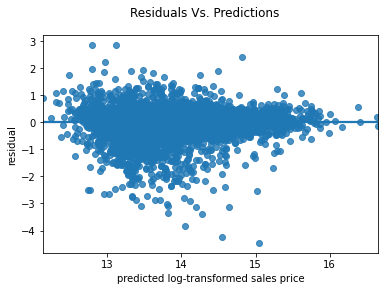

In [61]:
# calculate predictions and residuals and create a plot
log_zips_model_preds = log_zips_model.predict(sm.add_constant(log_transformed_zips))
resids = log_y - log_zips_model_preds

fig, ax = plt.subplots()

sns.regplot(log_zips_model_preds, resids)
ax.set_xlabel('predicted log-transformed sales price')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

Generally, it seems like there is a linear relationship between our predictor variables and our outcome, though there are also some large residuals. Let's check the other assumptions.

#### Assumption 2: the residuals are independent of each other.

We can check this assumption with the Durbin-Watson statistic, which is included in the summary of our model.

In [62]:
dw = sm.stats.stattools.durbin_watson
dw(resids)

1.9796432397124832

This value is very close to 2, which suggests there is no correlation between the residuals.

#### Assumption 3: the residuals of the model are normally distributed.

We can check this with a QQ plot.

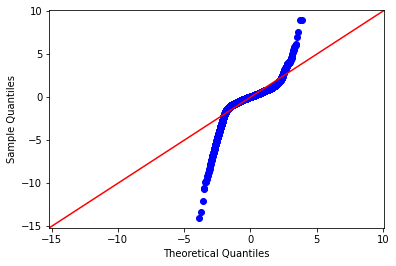

In [63]:
sm.graphics.qqplot(log_zips_model.resid, dist=stats.norm, line='45', fit=True)
plt.show();

Unfortunately, our residuals do not appear to be normally distributed. For listings with low sale prices our model's predictions are too high (below the red line to the left of the plot), and for listings with high sale prices our model's predictions are too low (above the red line to the right of the plot). However, for our business question, which focuses on the middle of the price distribution, our predictions appear to be relatively close to reality. For now, we will accept this imperfection and continue checking the other assumptions.

#### Assumption 4: The variance of the residuals is constant across all values of X.

This assumption is also called homoscedasticity. Heteroscedasticity leads to a higher risk of type II error, or false negative results, for the significance of our predictor variables. We can check this assumption with the same scatter plot used for assumption 1, which shows that our errors seem to have a greater spread for lower-priced listings. Again, because our business question is focused on the middle of the distribution, we will accept this for now and continue with our analysis.

#### Assumption 5: There is not significant multicollinearity between predictor variables.

We can check this by calculating the variance inflation factor (VIF) for each predictor variable. Variables with high VIFs can be predicted well by the other variables in the model, which indicates that the model overall may suffer from multicollinearity. We want our VIFs to be below 10, if possible.

In [64]:
vifs = {}
for i in log_transformed_zips.columns:
    vif = sm.OLS(endog=log_transformed_zips[i], exog=sm.add_constant(log_transformed_zips.drop(i, axis=1))).fit()
    vif = 1 / (1-vif.rsquared)
    vifs[i] = vif

<ipython-input-64-e9cfded11aca>:4: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1 / (1-vif.rsquared)


In [65]:
vifs

{'sqft_living_log': 9.668038408065547,
 'sqft_above_log': 8.338339370227658,
 'years_old_log': 2.3831475584918334,
 'bedrooms': 2.1530095924606227,
 'bathrooms': 3.197381438080949,
 'floors': 2.547410744875006,
 'view': 1.4942999472895493,
 'condition': 1.2542473575401132,
 'grade': 3.226051118228872,
 'avg_school_quality': inf,
 'waterfront_YES': 2.010809314064307,
 'greenbelt_YES': 1.5264458413903228,
 'nuisance_YES': 1.1408608454690863,
 'renovated_1': 1.3492027500024344,
 'zip_98001.0': inf,
 'zip_98002.0': inf,
 'zip_98003.0': inf,
 'zip_98004.0': inf,
 'zip_98005.0': inf,
 'zip_98006.0': inf,
 'zip_98007.0': inf,
 'zip_98008.0': inf,
 'zip_98010.0': inf,
 'zip_98011.0': inf,
 'zip_98014.0': inf,
 'zip_98019.0': inf,
 'zip_98022.0': inf,
 'zip_98023.0': inf,
 'zip_98024.0': inf,
 'zip_98027.0': inf,
 'zip_98028.0': inf,
 'zip_98029.0': inf,
 'zip_98030.0': inf,
 'zip_98031.0': inf,
 'zip_98032.0': inf,
 'zip_98033.0': inf,
 'zip_98034.0': inf,
 'zip_98038.0': inf,
 'zip_98039.0': 

For the most part, the VIF for our variables appears to be below 10. It makes sense that the ZIP codes and school ratings have high VIFs because we used ZIP codes to map school ratings into our dataset, which means they will be closely correlated. While our model does have some issues with multicollinearity, but we probably don't need to drop any variables to address it for now.

**Overall, while our model does not perfectly satisfy the assumptions of linear regression, it is likely good enough to move forward with addressing our business question.**

## Returning to the Business Question: Recommending a Zip Code to Buy In

Let's return to answering our business question: for a family of four or five people that is moving to King County, earning roughly 100,000 dollars per year, how can we make sure they are able to get a good value home and send their kids to a good school?

We can start answering this question by generating predicted sale prices for all of the homes in our dataset.

In [66]:
# create a dataframe of all the rows and predictor variable columns from our best model
bq_x = pd.concat([log_transformed_zips_test, log_transformed_zips])
bq_x.head()

,sqft_living_log,sqft_above_log,years_old_log,bedrooms,bathrooms,floors,view,condition,grade,avg_school_quality,waterfront_YES,greenbelt_YES,nuisance_YES,renovated_1,zip_98001.0,zip_98002.0,zip_98003.0,zip_98004.0,zip_98005.0,zip_98006.0,zip_98007.0,zip_98008.0,zip_98010.0,zip_98011.0,zip_98014.0,zip_98019.0,zip_98022.0,zip_98023.0,zip_98024.0,zip_98027.0,zip_98028.0,zip_98029.0,zip_98030.0,zip_98031.0,zip_98032.0,zip_98033.0,zip_98034.0,zip_98038.0,zip_98039.0,zip_98040.0,zip_98042.0,zip_98045.0,zip_98047.0,zip_98051.0,zip_98052.0,zip_98053.0,zip_98055.0,zip_98056.0,zip_98057.0,zip_98058.0,zip_98059.0,zip_98065.0,zip_98070.0,zip_98072.0,zip_98074.0,zip_98075.0,zip_98077.0,zip_98092.0,zip_98102.0,zip_98103.0,zip_98105.0,zip_98106.0,zip_98107.0,zip_98108.0,zip_98109.0,zip_98112.0,zip_98115.0,zip_98116.0,zip_98117.0,zip_98118.0,zip_98119.0,zip_98122.0,zip_98125.0,zip_98126.0,zip_98133.0,zip_98136.0,zip_98144.0,zip_98146.0,zip_98148.0,zip_98155.0,zip_98166.0,zip_98168.0,zip_98177.0,zip_98178.0,zip_98188.0,zip_98198.0,zip_98199.0
26790,7.774856,7.774856,2.833213,4.0,2.5,2.0,0.0,2.0,9.0,0.6,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8799,8.032685,8.032685,3.135494,5.0,3.0,2.0,0.0,2.0,9.0,1.9,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29276,7.610853,7.610853,4.262680,4.0,2.0,1.0,0.0,3.0,7.0,6.2,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29465,7.272398,7.272398,2.708050,3.0,2.5,2.0,0.0,2.0,6.0,2.1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
20719,7.305860,7.305860,2.197225,3.0,2.5,2.0,0.0,2.0,7.0,1.8,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# create a dataframe of all the rows and price column from our best model
bq_y = pd.concat([log_y_test, log_y])
bq_y.head()

26790    13.567049
8799     13.769467
29276    14.576316
29465    13.180538
20719    13.161584
Name: price, dtype: float64

In [68]:
# merge them into one dataframe with all variables
bq = pd.merge(bq_y, bq_x, left_on=bq_y.index, right_on=bq_x.index)
bq.head()

,key_0,price,sqft_living_log,sqft_above_log,years_old_log,bedrooms,bathrooms,floors,view,condition,grade,avg_school_quality,waterfront_YES,greenbelt_YES,nuisance_YES,renovated_1,zip_98001.0,zip_98002.0,zip_98003.0,zip_98004.0,zip_98005.0,zip_98006.0,zip_98007.0,zip_98008.0,zip_98010.0,zip_98011.0,zip_98014.0,zip_98019.0,zip_98022.0,zip_98023.0,zip_98024.0,zip_98027.0,zip_98028.0,zip_98029.0,zip_98030.0,zip_98031.0,zip_98032.0,zip_98033.0,zip_98034.0,zip_98038.0,zip_98039.0,zip_98040.0,zip_98042.0,zip_98045.0,zip_98047.0,zip_98051.0,zip_98052.0,zip_98053.0,zip_98055.0,zip_98056.0,zip_98057.0,zip_98058.0,zip_98059.0,zip_98065.0,zip_98070.0,zip_98072.0,zip_98074.0,zip_98075.0,zip_98077.0,zip_98092.0,zip_98102.0,zip_98103.0,zip_98105.0,zip_98106.0,zip_98107.0,zip_98108.0,zip_98109.0,zip_98112.0,zip_98115.0,zip_98116.0,zip_98117.0,zip_98118.0,zip_98119.0,zip_98122.0,zip_98125.0,zip_98126.0,zip_98133.0,zip_98136.0,zip_98144.0,zip_98146.0,zip_98148.0,zip_98155.0,zip_98166.0,zip_98168.0,zip_98177.0,zip_98178.0,zip_98188.0,zip_98198.0,zip_98199.0
0,26790,13.567049,7.774856,7.774856,2.833213,4.0,2.5,2.0,0.0,2.0,9.0,0.6,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8799,13.769467,8.032685,8.032685,3.135494,5.0,3.0,2.0,0.0,2.0,9.0,1.9,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29276,14.576316,7.610853,7.610853,4.262680,4.0,2.0,1.0,0.0,3.0,7.0,6.2,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29465,13.180538,7.272398,7.272398,2.708050,3.0,2.5,2.0,0.0,2.0,6.0,2.1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,20719,13.161584,7.305860,7.305860,2.197225,3.0,2.5,2.0,0.0,2.0,7.0,1.8,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# reset the index
bq.set_index('key_0', inplace = True)

In [70]:
# run model for full dataset
y = bq["price"]
X = bq.drop(columns=["price"])

bq_model = sm.OLS(y, sm.add_constant(X)).fit()
bq_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     782.6
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:24:32   Log-Likelihood:                -8145.8
No. Observations:               29143   AIC:                         1.647e+04
Df Residuals:                   29055   BIC:                         1.720e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                206.1942     19.676     10.479      0.000     167.628     244.760
sqft_living_log        0.2178      0.012     18.122      0.000       0.194       0.241
sqft_above_log         0.2619      0.011     23.641      0.000       0.240       0.284
years_old_log         -0.0086      0.003     -3.195      0.001      -0.014      -0.003
bedrooms              -0.0052      0.003     -1.854      0.064      -0.011       0.000
bathrooms              0.0397      0.004     10.626      0.000       0.032       0.047
floors                -0.0774      0.005    -14.230      0.000      -0.088      -0.067
view                   0.0666      0.003     25.331      0.000       0.061       0.072
condition              0.0635      0.003     21.450      0.000       0.058       0.069
grade                  0.0915      0.003     31.780      0.000       0.086       0.097
avg_school_quality   -60.7898      6.140     -9.900      0.000     -72.825     -48.754
waterfront_YES         0.3166      0.016     19.453      0.000       0.285       0.349
greenbelt_YES          0.0540      0.012      4.422      0.000       0.030       0.078
nuisance_YES          -0.0429      0.005     -8.331      0.000      -0.053      -0.033
renovated_1            0.0730      0.009      7.793      0.000       0.055       0.091
zip_98001.0         -160.8127     15.992    -10.056      0.000    -192.158    -129.467
zip_98002.0          -87.9442      8.624    -10.198      0.000    -104.848     -71.041
zip_98003.0          -75.7367      7.396    -10.240      0.000     -90.233     -61.240
zip_98004.0          107.9121     11.026      9.787      0.000      86.301     129.523
zip_98005.0           83.2782      8.570      9.717      0.000      66.480     100.076
zip_98006.0          143.8881     14.710      9.782      0.000     115.056     172.720
zip_98007.0          -50.6412      4.940    -10.251      0.000     -60.325     -40.958
zip_98008.0           95.2747      9.798      9.724      0.000      76.070     114.479
zip_98010.0           76.3775      7.956      9.600      0.000      60.784      91.971
zip_98011.0          -38.6698      3.712    -10.416      0.000     -45.946     -31.393
zip_98014.0           52.2726      5.500      9.504      0.000      41.492      63.053
zip_98019.0           34.0788      3.659      9.315      0.000      26.908      41.250
zip_98022.0          -75.6980      7.396    -10.235      0.000     -90.194     -61.202
zip_98023.0           -2.7891      0.099    -28.162      0.000      -2.983      -2.595
zip_98024.0          143.6932     14.710      9.768      0.000     114.861     172.526
zip_98027.0           70.7534      7.342      9.637      0.000      56.363      85.144
zip_98028.0          180.0877     18.395      9.790      0.000     144.034     216.142
zip_98029.0          113.4388     11.6

In [71]:
# generate predicted sale prices
bq_predict = bq_model.predict(sm.add_constant(X))

In [72]:
# add predicted sale prices as a column to dataframe
bq["predicted_sale_price"] = bq_predict

In [73]:
# transform from log to dollars
bq["price"] = np.exp(bq["price"])
bq["predicted_sale_price"] = np.exp(bq["predicted_sale_price"])
bq['residual'] = bq['price'] - bq["predicted_sale_price"]

In [74]:
# merge with original dataframe
hd_predictions = pd.merge(hd, bq[["predicted_sale_price", "residual"]], left_on = hd.index, right_on = bq.index)
hd_predictions.drop('key_0', inplace = True, axis = 1)
hd_predictions.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,years_old,sale_year,predicted_sale_price,residual
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,54,2022,5.289172e+05,146082.823905
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133,73,2021,9.803906e+05,-60390.550755
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178,67,2021,7.935100e+05,-482509.984683
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118,13,2021,1.011596e+06,-236595.668679
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027,11,2021,6.999917e+05,-107491.718229


In [75]:
# create subset to answer business question
hd_predictions_subset = hd_predictions[["bedrooms", "price", "predicted_sale_price", "residual", "zip"]]

It will be helpful for us to have a standardized measure of school quality to measure ZIP codes against each other, so we will use a standard scaler to create a new column with the z-score of each ZIP code's average school quality.

In [76]:
# add school quality column
hd_predictions_subset['avg_school_quality'] = hd_predictions_subset['zip'].map(schools_dict)

In [77]:
# scale school performance
ss = StandardScaler()
hd_predictions_subset['scaled_schools'] = ss.fit_transform(hd_predictions_subset[['avg_school_quality']])
hd_predictions_subset

,bedrooms,price,predicted_sale_price,residual,zip,avg_school_quality,scaled_schools
0,4,675000.0,5.289172e+05,146082.823905,98055,4.2,0.591324
1,5,920000.0,9.803906e+05,-60390.550755,98133,2.5,-0.422377
2,6,311000.0,7.935100e+05,-482509.984683,98178,0.4,-1.674597
3,3,775000.0,1.011596e+06,-236595.668679,98118,2.1,-0.660895
4,2,592500.0,6.999917e+05,-107491.718229,98027,4.4,0.710583
...,...,...,...,...,...,...,...
29138,5,1555000.0,1.203225e+06,351774.583184,98103,2.6,-0.362748
29139,3,1313000.0,1.078204e+06,234795.615539,98116,4.1,0.531695
29140,3,800000.0,8.273166e+05,-27316.573658,98122,0.5,-1.614967
29141,3,775000.0,7.209663e+05,54033.698385,98055,4.2,0.591324


Now that we have a standardized measure of school performance, we can subset our dataset further to focus only on houses that meet our clients' needs - namely, a market-rate price (between the 25th and 75th percentile) and enough bedrooms for their family (which we have defined as being anywhere between 2 and 5).

In [78]:
# define target market based on price and bedrooms
target_market = hd_predictions_subset.loc[(hd_predictions_subset['price'] <= 1300000) &
                                          (hd_predictions_subset['price'] >= 650000) &
                                          (hd_predictions_subset['bedrooms'] <= 5) &
                                          (hd_predictions_subset['bedrooms'] >= 2)]

In [79]:
# group by zip code to make recommendations
target_market_averages = target_market.groupby(by=["zip"]).mean().sort_values(by=["residual"],ascending= False)
target_market_averages

,bedrooms,price,predicted_sale_price,residual,avg_school_quality,scaled_schools
zip,,,,,,
98354,4.000000,7.485000e+05,5.452203e+05,203279.650036,NaN,NaN
98050,3.000000,7.500000e+05,5.994762e+05,150523.758083,NaN,NaN
98002,3.666667,7.417000e+05,6.145465e+05,127153.544278,1.8,-0.839784
98047,3.600000,6.690000e+05,5.510769e+05,117923.134912,3.3,0.054659
98188,3.666667,8.047973e+05,6.975295e+05,107267.873381,1.1,-1.257190
...,...,...,...,...,...,...
98075,3.574468,1.064952e+06,1.270767e+06,-205815.476535,6.0,1.664655
98005,3.166667,1.131778e+06,1.408349e+06,-276571.366564,4.6,0.829842
98033,3.244444,1.068909e+06,1.436277e+06,-367367.407197,5.5,1.366508


In [80]:
# drop zip codes with no schools
target_market_averages.dropna(inplace = True)
target_market_averages

,bedrooms,price,predicted_sale_price,residual,avg_school_quality,scaled_schools
zip,,,,,,
98002,3.666667,7.417000e+05,6.145465e+05,127153.544278,1.8,-0.839784
98047,3.600000,6.690000e+05,5.510769e+05,117923.134912,3.3,0.054659
98188,3.666667,8.047973e+05,6.975295e+05,107267.873381,1.1,-1.257190
98168,3.743590,7.396372e+05,6.358747e+05,103762.503610,0.0,-1.913115
98148,3.820513,7.890876e+05,6.872186e+05,101869.050469,0.3,-1.734226
...,...,...,...,...,...,...
98075,3.574468,1.064952e+06,1.270767e+06,-205815.476535,6.0,1.664655
98005,3.166667,1.131778e+06,1.408349e+06,-276571.366564,4.6,0.829842
98033,3.244444,1.068909e+06,1.436277e+06,-367367.407197,5.5,1.366508


Now we can create a plot to see which districts have the best mix of good value housing (which we are defining as, average sales price for that ZIP code that is less than our model would predict) and good schools (which we are defining as, a positive z-score which indicates good quality relative to the mean).

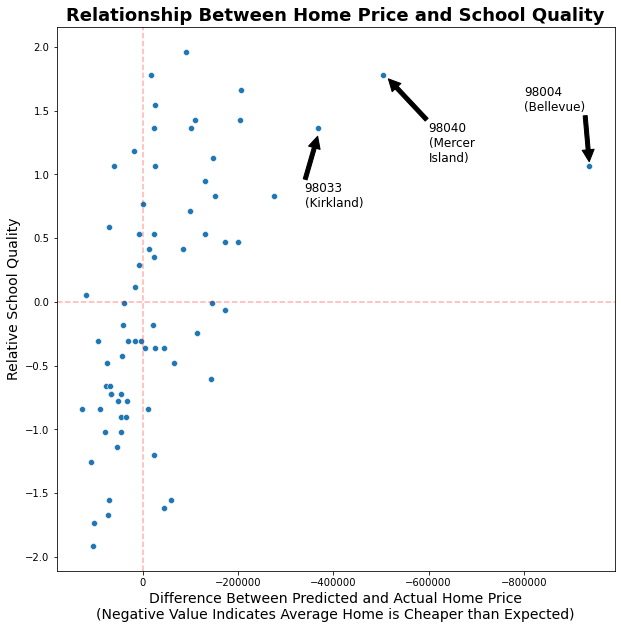

In [81]:
# initialize figure
fig, ax = plt.subplots(figsize = (10, 10))

# create scatterplot
sns.scatterplot(data = target_market_averages, 
                x = 'residual', 
                y = 'scaled_schools',
                legend = False, 
                palette='dodgerblue')

# flip axis because smaller residuals indicate better value
ax.invert_xaxis()

# draw lines to demarcate quadrants
plt.axhline(y=0, color='r', linestyle='--', alpha = 0.3)
plt.axvline(x=0, color='r', linestyle='--', alpha = 0.3)

# set axis labels and title
ax.set_xlabel('Difference Between Predicted and Actual Home Price\n(Negative Value Indicates Average Home is Cheaper than Expected)', fontsize = 14)
ax.set_ylabel('Relative School Quality', fontsize = 14)
ax.set_title('Relationship Between Home Price and School Quality', fontsize = 18, weight = 'bold');

# label specific zip codes of interest
ax.annotate('98004\n(Bellevue)',  \
            xy=(-937088.987114, 1.1), xytext=(-800000, 1.5),\
            arrowprops={'facecolor': 'black'}, fontsize = 12, c = 'black')
ax.annotate('98040\n(Mercer\nIsland)',  \
            xy=(-515690.694822, 1.75), xytext=(-600000, 1.1),\
            arrowprops={'facecolor': 'black'}, fontsize = 12, c = 'black')
ax.annotate('98033\n(Kirkland)',  \
            xy=(-367367.407197, 1.3), xytext=(-340000, .75),\
            arrowprops={'facecolor': 'black'}, fontsize = 12, c = 'black');

In [82]:
# Making a map
# Creating dataframe of zips, and average latitude and longitude
lat_long = hd[["zip", "lat", "long"]]
lat_long = lat_long.groupby(by=["zip"]).mean().reset_index()

In [83]:
lat_long

,zip,lat,long
0,98001,47.312228,-122.272730
1,98002,47.305170,-122.213682
2,98003,47.317451,-122.313209
3,98004,47.615162,-122.206244
4,98005,47.614877,-122.167621
...,...,...,...
71,98188,47.448735,-122.280329
72,98198,47.389992,-122.315116
73,98199,47.648772,-122.397926
74,98224,47.761321,-121.467981


In [84]:
map_data = pd.merge(lat_long, target_market_averages, left_on="zip", right_on=target_market_averages.index)

In [85]:
map_data

,zip,lat,long,bedrooms,price,predicted_sale_price,residual,avg_school_quality,scaled_schools
0,98001,47.312228,-122.272730,3.773109,7.820384e+05,7.113498e+05,70688.582524,0.6,-1.555338
1,98002,47.305170,-122.213682,3.666667,7.417000e+05,6.145465e+05,127153.544278,1.8,-0.839784
2,98003,47.317451,-122.313209,3.877193,8.049543e+05,7.387101e+05,66244.130842,2.0,-0.720525
3,98004,47.615162,-122.206244,3.285714,1.165423e+06,2.102512e+06,-937088.987114,5.0,1.068360
4,98005,47.614877,-122.167621,3.166667,1.131778e+06,1.408349e+06,-276571.366564,4.6,0.829842
...,...,...,...,...,...,...,...,...,...
67,98177,47.739091,-122.368874,3.266272,9.505049e+05,9.731269e+05,-22622.037638,2.9,-0.183859
68,98178,47.498690,-122.247793,3.605096,7.977637e+05,7.260240e+05,71739.721952,0.4,-1.674597
69,98188,47.448735,-122.280329,3.666667,8.047973e+05,6.975295e+05,107267.873381,1.1,-1.257190
70,98198,47.389992,-122.315116,3.752294,8.089349e+05,7.155484e+05,93386.559319,2.7,-0.303118


In [86]:
# Looking at schools that are better than average and are undervalued
map_data.loc[(df["residual"] <=0) & (map_data["scaled_schools"] >=0)].sort_values(by=["scaled_schools"], ascending=False)

NameError: name 'df' is not defined

In [ ]:
# Looking at schools with highest test scores
map_data.sort_values(by=["residual"], ascending=False).tail(20)

In [ ]:
# Building the map
import folium
map = folium.Map(location=[47.488098, -122.132028], default_zoom_start=5)

tooltip = "Click for more info"

folium.Marker([47.601088, -122.197172], popup="<b>98004</b> - <i>Bellevue, WA,</i> the best for our family", tooltip=tooltip).add_to(map)
folium.Marker([47.563692, -122.226786], popup="<b>98040</b> - <i>Mercer Island, WA,</i>", tooltip=tooltip).add_to(map)
folium.Marker([47.680695, -122.186660], popup="<b>98033</b> - <i>Kirkland, WA</i>", tooltip=tooltip).add_to(map)

map

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
